<a href="https://colab.research.google.com/github/VilmarJNR/ONE-TelecomX2-PrevendoChurn/blob/main/TelecomX2_PrevendoChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Telecom X – Parte 2: Prevendo Churn**

### **🎯 Missão e Objetivos**
A missão deste projeto é desenvolver modelos preditivos capazes de identificar, com antecedência, quais clientes possuem maior probabilidade de cancelar seus serviços com a Telecom X.

Para isso, será construído um pipeline robusto de modelagem que contempla as seguintes etapas:



* **Preparação dos dados**, incluindo tratamento de valores ausentes, codificação de variáveis categóricas e normalização.
* **Análise de correlação** entre variáveis e seleção de atributos relevantes.
* **Treinamento de múltiplos modelos de classificação** para comparação de desempenho.
* **Avaliação das métricas de performance** (como precisão, recall, F1-score, entre outras).
* **Interpretação dos resultados**, com destaque para a importância de cada variável no processo de previsão.
* **Elaboração de uma conclusão estratégica**, indicando os principais fatores que contribuem para a evasão de clientes.

O objetivo final é fornecer à empresa uma base analítica sólida que permita a adoção de medidas para retenção de clientes.


#1. **Importando Ferramentas**


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, auc, accuracy_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import warnings
warnings.filterwarnings('ignore')

#2. **Carregando e Explorando Inicialmente os Dados**


In [41]:
# Carregar os dados
df = pd.read_csv('/content/telecom_churn_model.csv')

In [42]:
# Visualização das 5 primeiras linhas junto da estrutura dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Idoso                                    7032 non-null   int64  
 1   Parceiro                                 7032 non-null   int64  
 2   Dependentes                              7032 non-null   int64  
 3   Meses_Contrato                           7032 non-null   int64  
 4   Servico_Telefonico                       7032 non-null   int64  
 5   Multiplas_Linhas                         7032 non-null   int64  
 6   Seguranca_Online                         7032 non-null   int64  
 7   Backup_Online                            7032 non-null   int64  
 8   Protecao_Dispositivo                     7032 non-null   int64  
 9   Suporte_Tecnico                          7032 non-null   int64  
 10  Streaming_TV                             7032 no

#3. **Remoção de Colunas Irrelevantes**

In [43]:
# Visualização de colunas atuais
print("Colunas antes da remoção:")
print(df.columns.tolist())
print(f"\nNúmero de colunas antes: {df.shape[1]}")

Colunas antes da remoção:
['Idoso', 'Parceiro', 'Dependentes', 'Meses_Contrato', 'Servico_Telefonico', 'Multiplas_Linhas', 'Seguranca_Online', 'Backup_Online', 'Protecao_Dispositivo', 'Suporte_Tecnico', 'Streaming_TV', 'Streaming_Filmes', 'Fatura_Online', 'Gasto_Mensal', 'Gasto_Total', 'Cancelado', 'Sexo_Male', 'Servico_Internet_Fiber optic', 'Servico_Internet_No', 'Tipo_Contrato_One year', 'Tipo_Contrato_Two year', 'Forma_Pagamento_Credit card (automatic)', 'Forma_Pagamento_Electronic check', 'Forma_Pagamento_Mailed check']

Número de colunas antes: 24


#4. **Encoding**

In [44]:
# Criação de uma cópia do DataFrame, por garantia.
df_encoded = df.copy()

# identificando as colunas categóricas que ainda não são numéricas
colunas_categoricas = df_encoded.select_dtypes(include=['object']).columns.tolist()

print("Colunas categóricas a serem transformadas:", colunas_categoricas)
print(f"\nNúmero de colunas antes do encoding: {df_encoded.shape[1]}")

# Aplicando one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=colunas_categoricas, drop_first=True, dtype=int)

# Exibindo o resultado
print(f"\nNúmero de colunas após o encoding: {df_encoded.shape[1]}")
print("\nAs 5 primeiras linhas do DataFrame :")
display(df_encoded.head())

print("\nTipos de dados após a transformação:")
df_encoded.info()

Colunas categóricas a serem transformadas: []

Número de colunas antes do encoding: 24

Número de colunas após o encoding: 24

As 5 primeiras linhas do DataFrame :


,Idoso,Parceiro,Dependentes,Meses_Contrato,Servico_Telefonico,Multiplas_Linhas,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,...,Gasto_Total,Cancelado,Sexo_Male,Servico_Internet_Fiber optic,Servico_Internet_No,Tipo_Contrato_One year,Tipo_Contrato_Two year,Forma_Pagamento_Credit card (automatic),Forma_Pagamento_Electronic check,Forma_Pagamento_Mailed check
0,0,1,1,9,1,0,0,1,0,1,...,593.30,0.0,False,False,False,True,False,False,False,True
1,0,0,0,9,1,1,0,0,0,0,...,542.40,0.0,True,False,False,False,False,False,False,True
2,0,0,0,4,1,0,0,0,1,0,...,280.85,1.0,True,True,False,False,False,False,True,False
3,1,1,0,13,1,0,0,1,1,0,...,1237.85,1.0,True,True,False,False,False,False,True,False
4,1,1,0,3,1,0,0,0,0,1,...,267.40,1.0,False,True,False,False,False,False,False,True



Tipos de dados após a transformação:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Idoso                                    7032 non-null   int64  
 1   Parceiro                                 7032 non-null   int64  
 2   Dependentes                              7032 non-null   int64  
 3   Meses_Contrato                           7032 non-null   int64  
 4   Servico_Telefonico                       7032 non-null   int64  
 5   Multiplas_Linhas                         7032 non-null   int64  
 6   Seguranca_Online                         7032 non-null   int64  
 7   Backup_Online                            7032 non-null   int64  
 8   Protecao_Dispositivo                     7032 non-null   int64  
 9   Suporte_Tecnico                          7032 non-null   int64  
 10  Streaming_

#5. **Verificação da Proporção de Evasão**

Contagem de clientes por classe de Cancelamento:
Cancelado
0.0    5163
1.0    1869
Name: count, dtype: int64

Lembrete: 0 = Não Cancelado (Permaneceu), 1 = Cancelado (Evadiu)

Proporção de clientes por classe de cancelamento (em porcentagem):
Cancelado
0.0    73.42
1.0    26.58
Name: proportion, dtype: float64

- Avaliação do Desequilíbrio:
Há um desequilíbrio notável entre classes. A classe majoritária (Não Cancelado) representa 73.4% do total.
Isso deve ser levado em conta quando for fazer a avaliação dos modelos.


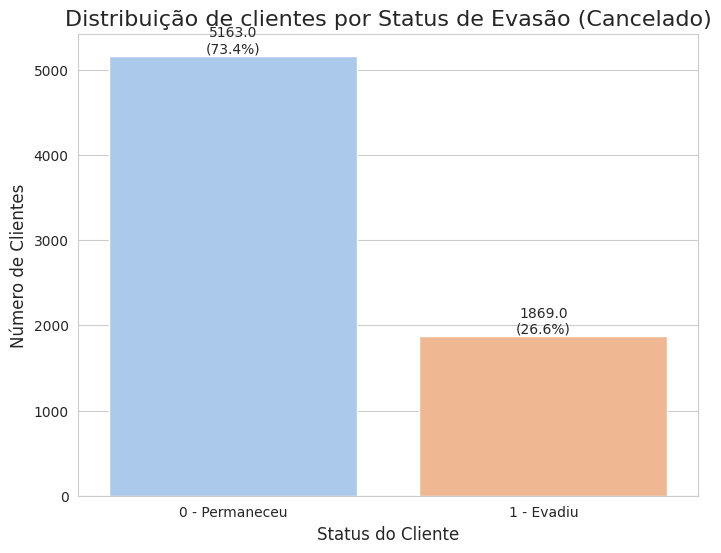

In [45]:
# Verificando a contagem de cada classe na coluna 'Cancelado'
contagem_Cancelado = df_encoded['Cancelado'].value_counts()
print("Contagem de clientes por classe de Cancelamento:")
print(contagem_Cancelado)
print("\nLembrete: 0 = Não Cancelado (Permaneceu), 1 = Cancelado (Evadiu)")

# Calculando a proporção em porcentagem
proporcao_Cancelado = df_encoded['Cancelado'].value_counts(normalize=True) * 100
print("\nProporção de clientes por classe de cancelamento (em porcentagem):")
print(proporcao_Cancelado.round(2))

# Avaliação de desequilíbrio
print ("\n- Avaliação do Desequilíbrio:")
if abs(proporcao_Cancelado[0] - proporcao_Cancelado[1]) > 20:
    print("Há um desequilíbrio notável entre classes. A classe majoritária (Não Cancelado) representa "
          f"{proporcao_Cancelado[0]:.1f}% do total.")
    print("Isso deve ser levado em conta quando for fazer a avaliação dos modelos.")
else:
    print("O desequilíbrio entre as classes é moderado.")

# Visualização da proporção com um gráfico de barras
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Cancelado', data=df_encoded, palette='pastel')
plt.title('Distribuição de clientes por Status de Evasão (Cancelado)', fontsize=16)
plt.xlabel('Status do Cliente', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 - Permaneceu', '1 - Evadiu'])

# Adicionando os rótulos de contagem e porcentagem
total = len(df_encoded['Cancelado'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height +3,
            f'{height}\n({(height/total)*100:.1f}%)',
            ha="center", va='bottom')

plt.show()

#6. **Normalização ou Padronização**

In [46]:
# Usado o df_encoded que foi gerado na etapa de encoding
df_para_escalar = df_encoded.copy()

# A normalização só é aplicada nas features que usarão para prever.
X = df_para_escalar.drop('Cancelado', axis=1)
y = df_para_escalar['Cancelado'] # Alvo permanece o mesmo (0s e 1s)

print("Shape das features (X) antes de escalar:", X.shape)
print("Shape do alvo (y):", y.shape)

# Criando o objeto scaler
scaler = MinMaxScaler()

# Aplicando a normalização nas features (X)
# O método fit_transform aprende os parâmetros (min/max) e transforma os dados
X_scaled = scaler.fit_transform(X)

# A saída do scaler é um array NumPy, que será convertido de volta para um
# DataFrame para manter os nomes das colunas, facilitando a análise de
# correlação
df_final = pd.DataFrame(X_scaled, columns=X.columns)

# Exibindo o resultado da normalização
print("\n Dados Após a Normalização:")
print("As 5 primeiras linhas dos dados normalizados:")
display(df_final.head())

print("\nEstatísticas descritivas ('min' é 0 e 'max' é 1 para todas as colunas):")
display(df_final.describe().round(2))

Shape das features (X) antes de escalar: (7032, 23)
Shape do alvo (y): (7032,)

 Dados Após a Normalização:
As 5 primeiras linhas dos dados normalizados:


,Idoso,Parceiro,Dependentes,Meses_Contrato,Servico_Telefonico,Multiplas_Linhas,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,...,Gasto_Mensal,Gasto_Total,Sexo_Male,Servico_Internet_Fiber optic,Servico_Internet_No,Tipo_Contrato_One year,Tipo_Contrato_Two year,Forma_Pagamento_Credit card (automatic),Forma_Pagamento_Electronic check,Forma_Pagamento_Mailed check
0,0.0,1.0,1.0,0.112676,1.0,0.0,0.0,1.0,0.0,1.0,...,0.471144,0.066294,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.112676,1.0,1.0,0.0,0.0,0.0,0.0,...,0.414428,0.060420,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.042254,1.0,0.0,0.0,0.0,1.0,0.0,...,0.553731,0.030239,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,0.169014,1.0,0.0,0.0,1.0,1.0,0.0,...,0.793532,0.140670,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.028169,1.0,0.0,0.0,0.0,0.0,1.0,...,0.653234,0.028687,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0



Estatísticas descritivas ('min' é 0 e 'max' é 1 para todas as colunas):


,Idoso,Parceiro,Dependentes,Meses_Contrato,Servico_Telefonico,Multiplas_Linhas,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,...,Gasto_Mensal,Gasto_Total,Sexo_Male,Servico_Internet_Fiber optic,Servico_Internet_No,Tipo_Contrato_One year,Tipo_Contrato_Two year,Forma_Pagamento_Credit card (automatic),Forma_Pagamento_Electronic check,Forma_Pagamento_Mailed check
count,7032.00,7032.00,7032.00,7032.00,7032.0,7032.00,7032.00,7032.00,7032.00,7032.00,...,7032.00,7032.00,7032.0,7032.00,7032.00,7032.00,7032.00,7032.00,7032.00,7032.00
mean,0.16,0.48,0.30,0.44,0.9,0.42,0.29,0.34,0.34,0.29,...,0.46,0.26,0.5,0.44,0.22,0.21,0.24,0.22,0.34,0.23
std,0.37,0.50,0.46,0.35,0.3,0.49,0.45,0.48,0.48,0.45,...,0.30,0.26,0.5,0.50,0.41,0.41,0.43,0.41,0.47,0.42
min,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.11,1.0,0.00,0.00,0.00,0.00,0.00,...,0.17,0.04,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.39,1.0,0.00,0.00,0.00,0.00,0.00,...,0.52,0.16,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,1.00,1.00,0.76,1.0,1.00,1.00,1.00,1.00,1.00,...,0.71,0.44,1.0,1.00,0.00,0.00,0.00,0.00,1.00,0.00
max,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#7. **Correlação e Seleção de Variáveis**


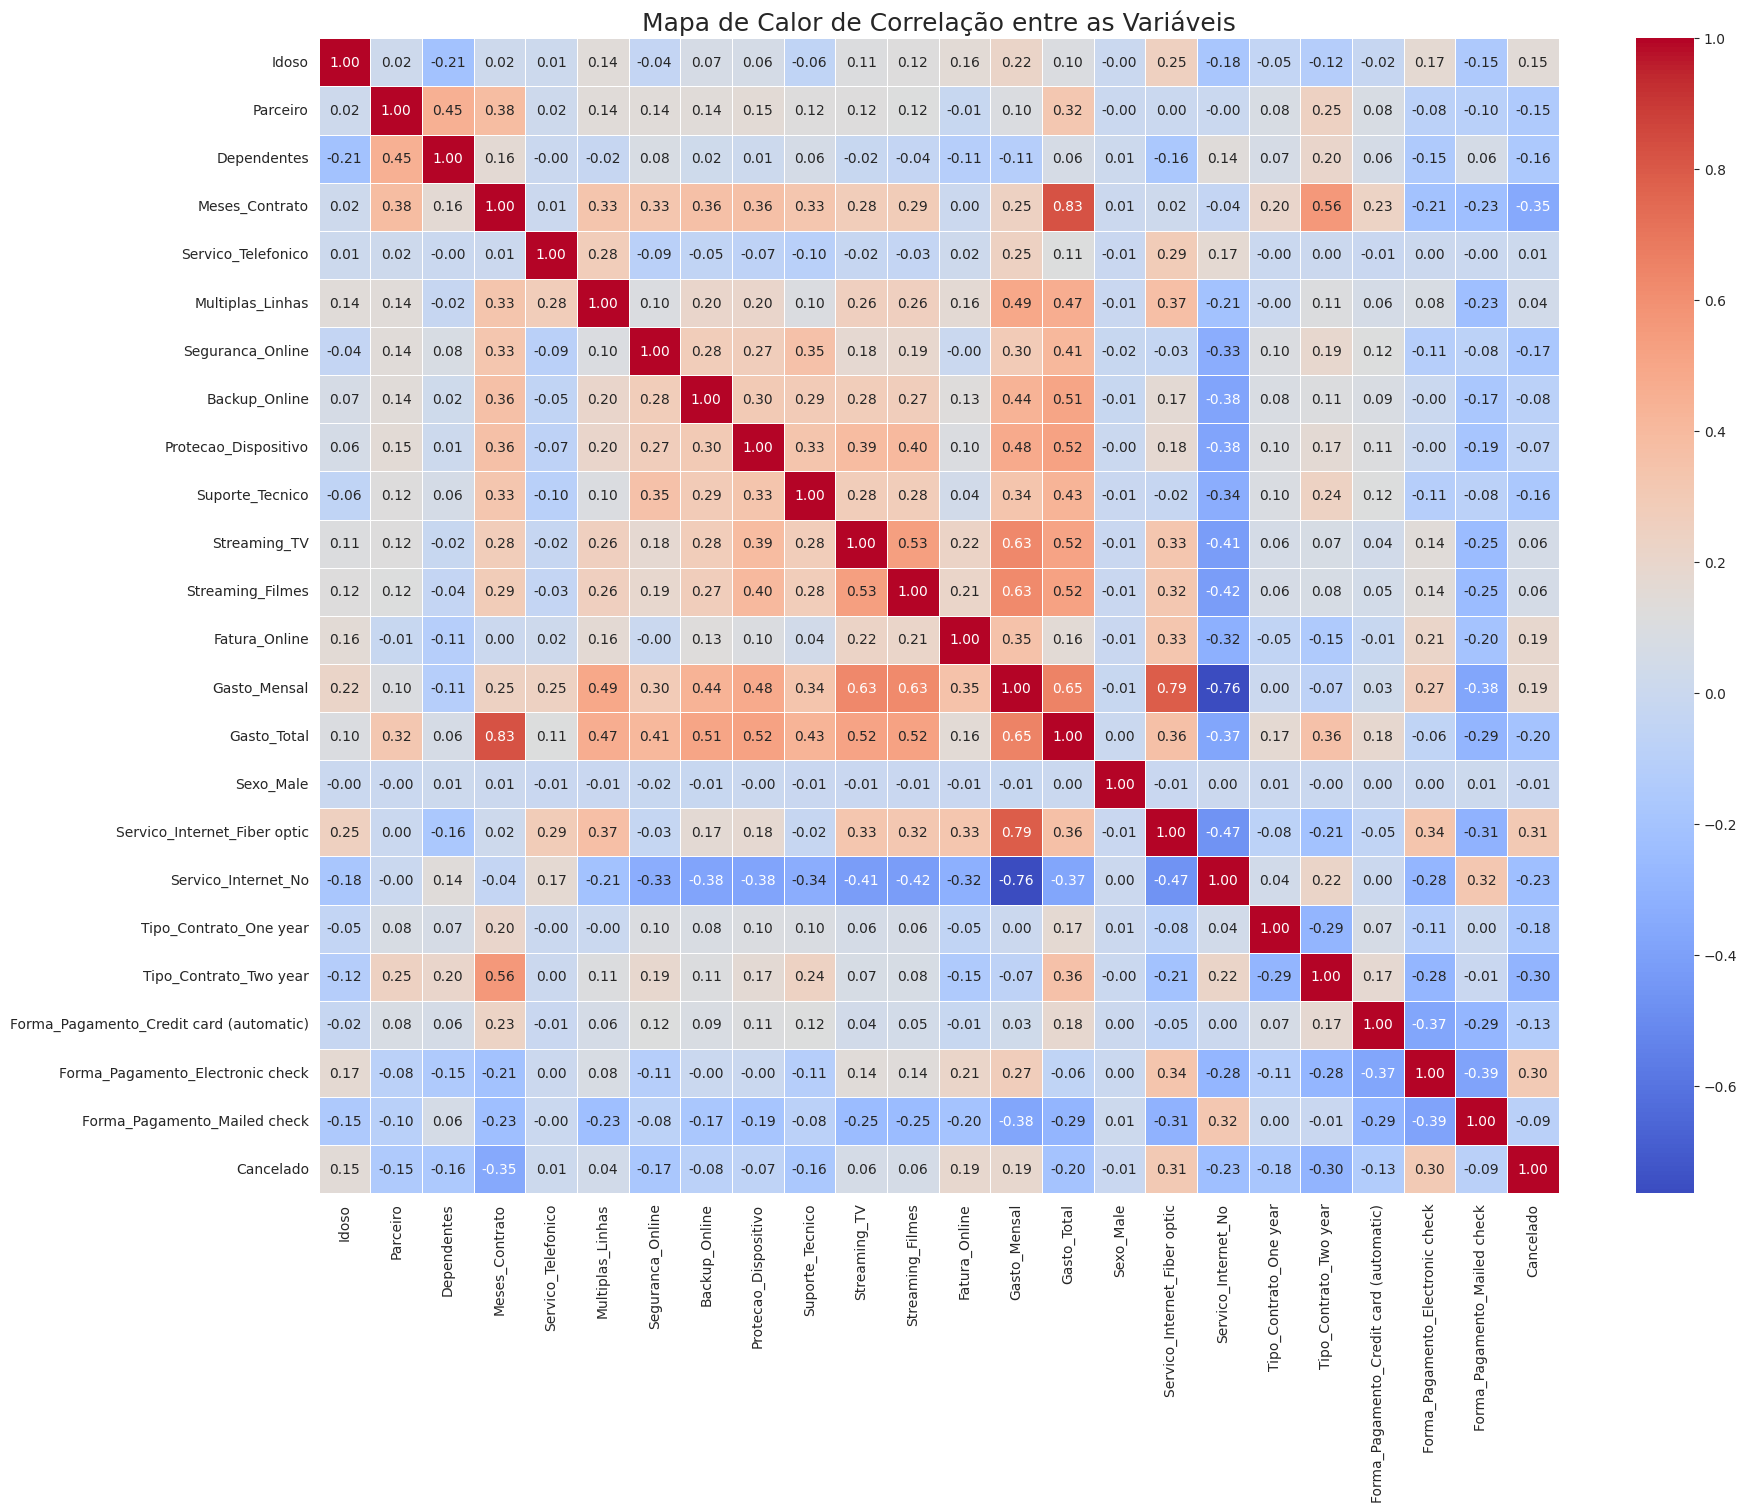

In [47]:
# Juntando as features normalizadas (X_scaled_df ou df_final) e o alvo (y)
# para a análise de correlação completa.
df_para_corr = pd.concat([df_final, y], axis=1)

# Calculando a matriz de correlação
corr_matrix = df_para_corr.corr()

# Criando o mapa de calor para visualizar a matriz
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix,
            annot=True,      # Exibe os valores de correlação
            cmap='coolwarm', # Esquema de cores
            fmt='.2f',       # Formata os números para duas casas decimais
            linewidths=.5)
plt.title('Mapa de Calor de Correlação entre as Variáveis', fontsize=18)
plt.show()

#8. **Análises Direcionadas**
### Tempo de Contrato x Evasão

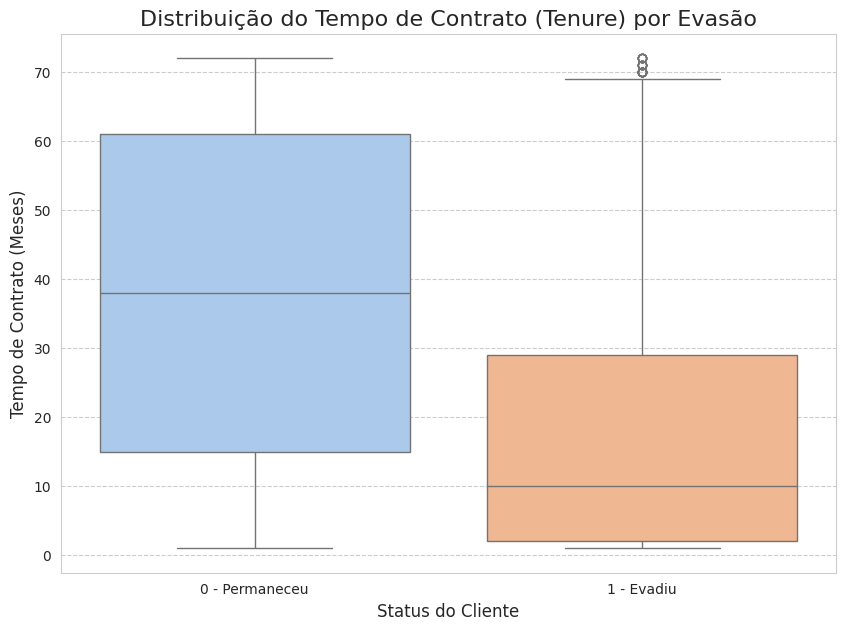

In [48]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Cancelado', y='Meses_Contrato', data=df_encoded, palette='pastel')
plt.title('Distribuição do Tempo de Contrato (Tenure) por Evasão', fontsize=16)
plt.xlabel('Status do Cliente', fontsize=12)
plt.ylabel('Tempo de Contrato (Meses)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 - Permaneceu', '1 - Evadiu'])
plt.grid(axis='y', linestyle='--')
plt.show()

### Total Gasto x Evasão

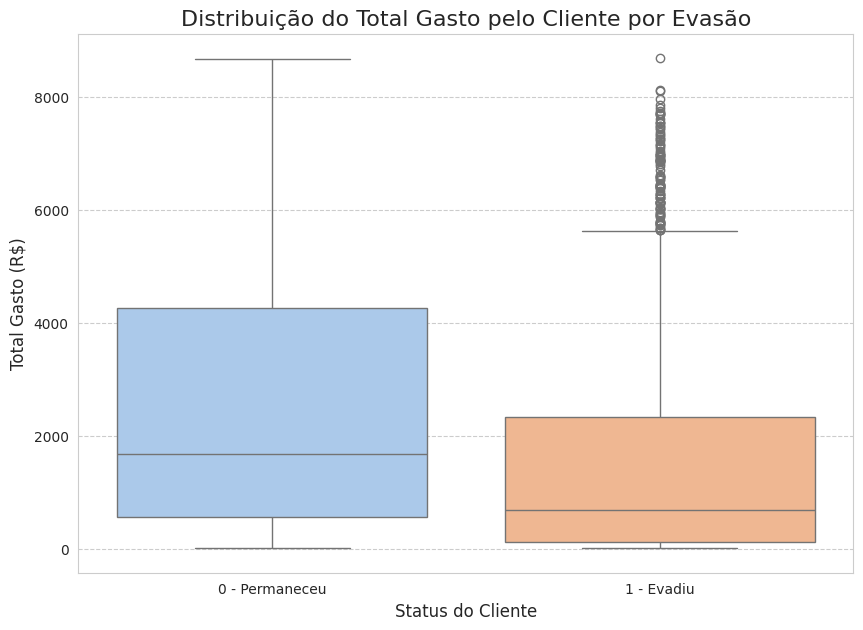

In [49]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Cancelado', y='Gasto_Total', data=df_encoded, palette='pastel')
plt.title('Distribuição do Total Gasto pelo Cliente por Evasão', fontsize=16)
plt.xlabel('Status do Cliente', fontsize=12)
plt.ylabel('Total Gasto (R$)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 - Permaneceu', '1 - Evadiu'])
plt.grid(axis='y', linestyle='--')
plt.show()

#9. **Modelagem Preditiva**

In [50]:
# Dividindo os dados em 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X,                # As features (preditores)
    y,                # A variável alvo
    test_size=0.3,    # Proporção dos dados para o conjunto de teste (30%)
    random_state=42,  # Garante que a divisão seja sempre a mesma ao rodar o código
    stratify=y        # Essencial para manter a proporção de Churn nos dois conjuntos
)

# Verificando as dimensões (shapes) dos conjuntos criados
print("--- Dimensões dos Conjuntos de Dados ---")
print(f"Shape de X_train (features de treino): {X_train.shape}")
print(f"Shape de X_test (features de teste):  {X_test.shape}")
print(f"Shape de y_train (alvo de treino):     {y_train.shape}")
print(f"Shape de y_test (alvo de teste):      {y_test.shape}")

# Verificando a proporção da variável alvo para confirmar a estratificação
print("\n--- Verificação da Estratificação (Proporção de Churn) ---")
print("Proporção no y_train (%):")
print(round(y_train.value_counts(normalize=True) * 100, 2))
print("\nProporção no y_test (%):")
print(round(y_test.value_counts(normalize=True) * 100, 2))

--- Dimensões dos Conjuntos de Dados ---
Shape de X_train (features de treino): (4922, 23)
Shape de X_test (features de teste):  (2110, 23)
Shape de y_train (alvo de treino):     (4922,)
Shape de y_test (alvo de teste):      (2110,)

--- Verificação da Estratificação (Proporção de Churn) ---
Proporção no y_train (%):
Cancelado
0.0    73.43
1.0    26.57
Name: proportion, dtype: float64

Proporção no y_test (%):
Cancelado
0.0    73.41
1.0    26.59
Name: proportion, dtype: float64


#10. **Criação de Modelos**
### Modelo_1: Regressão Logística

In [51]:
# Instanciar o modelo
log_reg = LogisticRegression(random_state=42, solver='liblinear')

# Treinar o modelo com os dados de treino
print("Treinando o modelo de Regressão Logística com solver 'liblinear'...")
log_reg.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_log_reg = log_reg.predict(X_test)

# Avaliar a performance do modelo
print("\n--- Resultados da Regressão Logística no Conjunto de Teste ---")
accuracy_log = accuracy_score(y_test, y_pred_log_reg)
print(f"Acurácia: {accuracy_log * 100:.2f}%")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_log_reg))

Treinando o modelo de Regressão Logística com solver 'liblinear'...
Treinamento concluído!

--- Resultados da Regressão Logística no Conjunto de Teste ---
Acurácia: 80.24%

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1549
         1.0       0.66      0.52      0.58       561

    accuracy                           0.80      2110
   macro avg       0.75      0.71      0.73      2110
weighted avg       0.79      0.80      0.79      2110



### Modelo_2: Random Forest

In [52]:
# Instanciar o modelo
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo com os mesmos dados de treino
print("\nTreinando o modelo de Random Forest...")
rf_clf.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_rf = rf_clf.predict(X_test)

# Avaliar a performance inicial do modelo
print("\n--- Resultados do Random Forest no Conjunto de Teste ---")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia: {accuracy_rf * 100:.2f}%")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))


Treinando o modelo de Random Forest...
Treinamento concluído!

--- Resultados do Random Forest no Conjunto de Teste ---
Acurácia: 78.48%

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      1549
         1.0       0.63      0.48      0.54       561

    accuracy                           0.78      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110



#11. **Avaliação dos Modelos**
### Modelo_1: Regressão Logística

--- Resultados da Regressão Logística ---
                precision    recall  f1-score   support

Permaneceu (0)       0.84      0.91      0.87      1549
    Evadiu (1)       0.66      0.52      0.58       561

      accuracy                           0.80      2110
     macro avg       0.75      0.71      0.73      2110
  weighted avg       0.79      0.80      0.79      2110

--- Matriz de Confusão ---


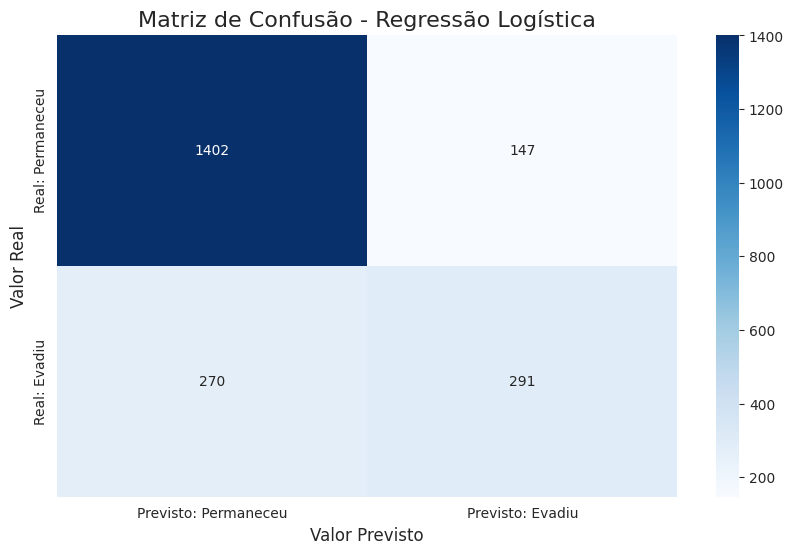

In [53]:
# Exibindo o relatório de classificação para referência
print("--- Resultados da Regressão Logística ---")
print(classification_report(y_test, y_pred_log_reg, target_names=['Permaneceu (0)', 'Evadiu (1)']))

# Criando e visualizando a Matriz de Confusão
print("--- Matriz de Confusão ---")
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto: Permaneceu', 'Previsto: Evadiu'],
            yticklabels=['Real: Permaneceu', 'Real: Evadiu'])
plt.title('Matriz de Confusão - Regressão Logística', fontsize=16)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Previsto', fontsize=12)
plt.show()

### Modelo_2: Random Forest (Avaliando)


--- Resultados do Random Forest ---
                precision    recall  f1-score   support

Permaneceu (0)       0.83      0.90      0.86      1549
    Evadiu (1)       0.63      0.48      0.54       561

      accuracy                           0.78      2110
     macro avg       0.73      0.69      0.70      2110
  weighted avg       0.77      0.78      0.77      2110


--- Matriz de Confusão ---


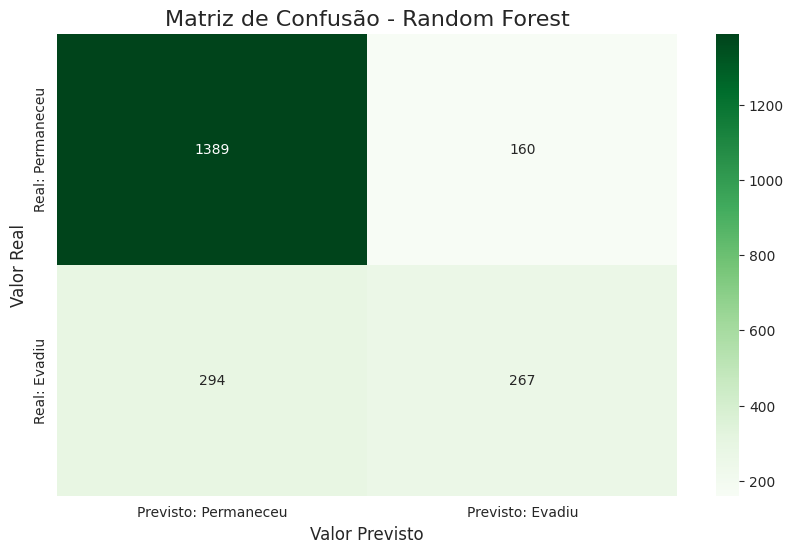

In [54]:
# Exibindo o relatório de classificação para referência
print("\n--- Resultados do Random Forest ---")
print(classification_report(y_test, y_pred_rf, target_names=['Permaneceu (0)', 'Evadiu (1)']))

# Criando e visualizando a Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Previsto: Permaneceu', 'Previsto: Evadiu'],
            yticklabels=['Real: Permaneceu', 'Real: Evadiu'])
plt.title('Matriz de Confusão - Random Forest', fontsize=16)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Previsto', fontsize=12)
plt.show()

#12. **Overfitting ou Underfitting?**

In [55]:
# Calculando a acurácia nos dados de treino para ambos os modelos
acc_log_train = accuracy_score(y_train, log_reg.predict(X_train))
acc_rf_train = accuracy_score(y_train, rf_clf.predict(X_train))

# Calculando a acurácia nos dados de teste
acc_log_test = accuracy_score(y_test, y_pred_log_reg)
acc_rf_test = accuracy_score(y_test, y_pred_rf)

print("--- Verificação de Overfitting ---")
print(f"Acurácia da Regressão Logística (Treino): {acc_log_train * 100:.2f}%")
print(f"Acurácia da Regressão Logística (Teste):  {acc_log_test * 100:.2f}%")
print("-" * 30)
print(f"Acurácia do Random Forest (Treino): {acc_rf_train * 100:.2f}%")
print(f"Acurácia do Random Forest (Teste):  {acc_rf_test * 100:.2f}%")

--- Verificação de Overfitting ---
Acurácia da Regressão Logística (Treino): 80.66%
Acurácia da Regressão Logística (Teste):  80.24%
------------------------------
Acurácia do Random Forest (Treino): 99.86%
Acurácia do Random Forest (Teste):  78.48%


### Análise de Overfitting:


1.   Regressão Logística: As acurácias de treino e teste são muito próximas (80.66% no treino e 80.24% no teste). Isso indica que o modelo está bem justo e não sofre de overfitting.
2.   Random Forest: A acurácia de treino é altíssima (proximo de 100%), enquanto a de teste é 78.48%. Portanto é overfitting. O modelo decorou os dados de treino tão bem que acabou perdendo a capacidade de generalizar para dados novos.



# 13. **Interpretação e Conclusões**
### Análise para Regressão Logística:

--- Coeficientes da Regressão Logística (Fatores de Churn) ---
                                    Feature  Coefficient
16             Servico_Internet_Fiber optic     0.439852
12                            Fatura_Online     0.361867
21         Forma_Pagamento_Electronic check     0.345100
0                                     Idoso     0.303726
5                          Multiplas_Linhas     0.142955
10                             Streaming_TV     0.102806
11                         Streaming_Filmes     0.026346
13                             Gasto_Mensal     0.010360
14                              Gasto_Total     0.000319
15                                Sexo_Male    -0.032396
1                                  Parceiro    -0.056114
3                            Meses_Contrato    -0.065024
8                      Protecao_Dispositivo    -0.101095
2                               Dependentes    -0.152853
7                             Backup_Online    -0.167139
20  Forma_Pagamento_Credi

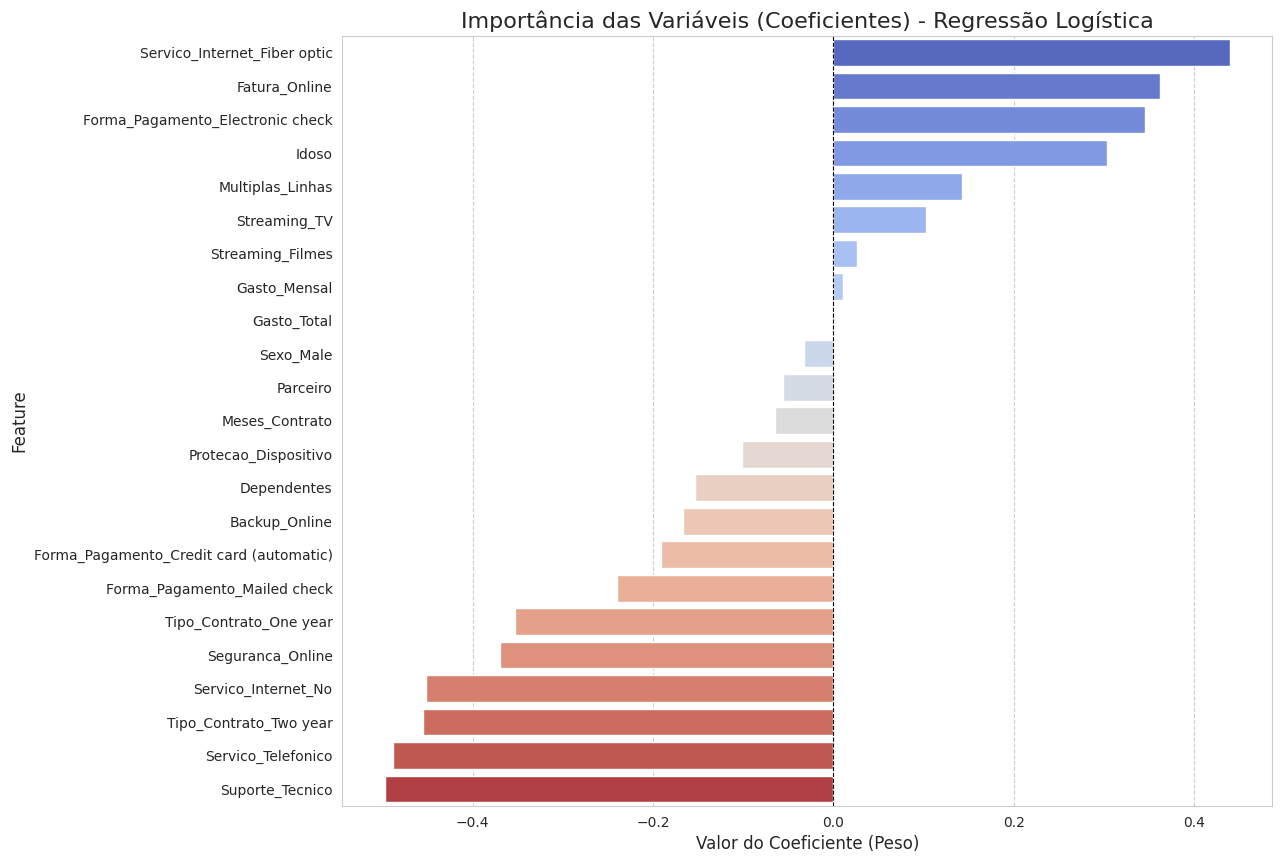

In [56]:
# Criando um DataFrame para visualizar os coeficientes da Regressão Logística
log_coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
})

# Ordenando os coeficientes para ver os mais influentes (positivos e negativos)
log_coeffs_sorted = log_coeffs.sort_values(by='Coefficient', ascending=False)

print("--- Coeficientes da Regressão Logística (Fatores de Churn) ---")
print(log_coeffs_sorted)

# Visualização dos coeficientes em um gráfico de barras
plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=log_coeffs_sorted, palette='coolwarm')
plt.title('Importância das Variáveis (Coeficientes) - Regressão Logística', fontsize=16)
plt.xlabel('Valor do Coeficiente (Peso)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', linestyle='--')
plt.show()

### Análise para Random Forest:


--- Importância das Features - Random Forest ---
                                    Feature  Importance
14                              Gasto_Total    0.195246
13                             Gasto_Mensal    0.176372
3                            Meses_Contrato    0.166749
16             Servico_Internet_Fiber optic    0.048290
21         Forma_Pagamento_Electronic check    0.043860
15                                Sexo_Male    0.029269
19                   Tipo_Contrato_Two year    0.028825
12                            Fatura_Online    0.027710
1                                  Parceiro    0.023489
9                           Suporte_Tecnico    0.023225
6                          Seguranca_Online    0.022918
18                   Tipo_Contrato_One year    0.022908
7                             Backup_Online    0.022444
0                                     Idoso    0.022003
5                          Multiplas_Linhas    0.020465
2                               Dependentes    0.02003

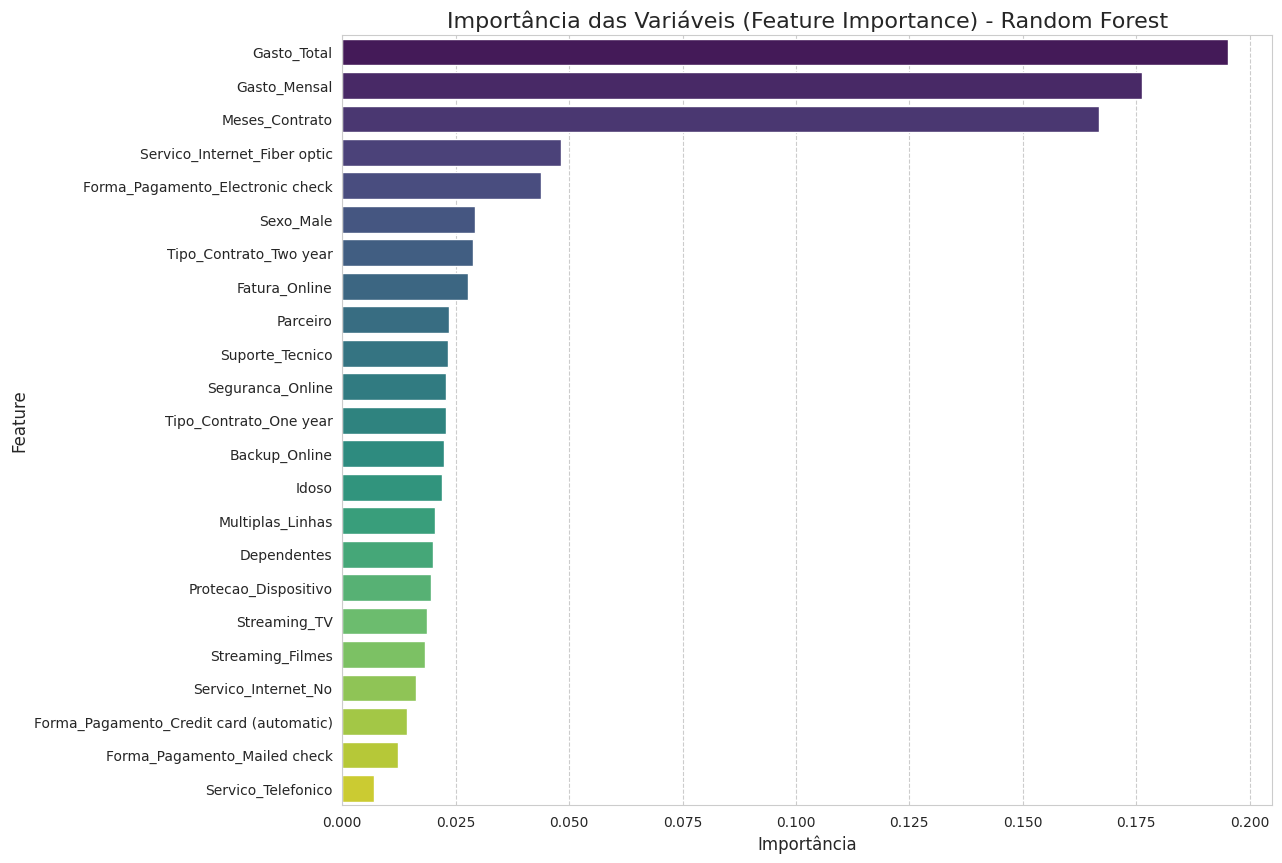

In [57]:
# Criando um DataFrame para visualizar a importância das features do Random Forest
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_clf.feature_importances_
})

# Ordenando as features pela sua importância
rf_importances_sorted = rf_importances.sort_values(by='Importance', ascending=False)

print("\n--- Importância das Features - Random Forest ---")
print(rf_importances_sorted)

# Visualização da importância em um gráfico de barras
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=rf_importances_sorted, palette='viridis')
plt.title('Importância das Variáveis (Feature Importance) - Random Forest', fontsize=16)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--')
plt.show()